In [10]:
import numpy as np
import time
import progressbar
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import SimpleITK as sitk
import scipy.misc as misc
import scipy.ndimage as snd
import imageio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import h5py
%matplotlib inline

In [11]:
x = h5py.File('/home/ryan/stark/Medical_ImageSegmentation_UNET/data/2qDLiverSlices_128.h5','r')
images = x['image'][:]
labels = x['label'][:]
x.close

<bound method File.close of <HDF5 file "2qDLiverSlices_128.h5" (mode r)>>

In [12]:
print(labels.shape)
print(images.shape)


(2000, 128, 128)
(2000, 128, 128)


In [13]:
train_images = images[:1500]
train_labels = labels[:1500]
val_images = images[1500:]
val_labels = labels[1500:] 

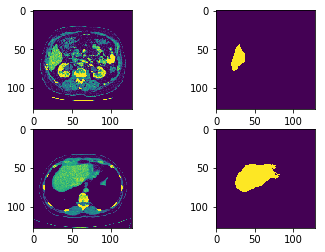

In [14]:
plt.figure()
plt.subplot(2,2,1)
plt.imshow(train_images[0])

plt.subplot(2,2,2)
plt.imshow(train_labels[0])
plt.subplot(2,2,3)
plt.imshow(val_images[10])

plt.subplot(2,2,4)
plt.imshow(val_labels[10])


In [15]:
class UNet(nn.Module):
    
    def __init__(self):
        
        super(UNet, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        self.conv4 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        
        self.upconv1 = nn.Sequential(nn.ConvTranspose2d(128,128,stride=2, kernel_size=2), nn.BatchNorm2d(128))
        self.conv5 = nn.Sequential(nn.Conv2d(128,64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        
        self.upconv2 = nn.Sequential(nn.ConvTranspose2d(128,32,stride=2, kernel_size=2), nn.BatchNorm2d(32))
        self.conv6 = nn.Sequential(nn.Conv2d(32,2, kernel_size=3, padding=1), nn.BatchNorm2d(2))
        
    def forward(self, x):
        
        x = F.relu(self.conv2(F.relu(self.conv1(x))), inplace=True)
        x_0 = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv4(F.relu(self.conv3(x_0))), inplace=True)
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv5(F.relu(self.upconv1(x))))
        x = torch.cat([x,x_0], 1)
        x = self.conv6(F.relu(self.upconv2(x)))
        x = F.log_softmax(x, dim=1)
        
        return x

In [16]:
class SimpleTrainer(object):
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
    def forward_backward(self,inputs, labels):
        self.inputs = inputs
        self.labels = labels
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        inputs = Variable(inputs).cuda()
        labels = Variable(labels).cuda()
        self.optimizer.zero_grad()
        outputs = self.model.forward(inputs)
        loss = self.loss_fn(outputs, labels)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def forward(self ,inputs, labels):
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        inputs = Variable(inputs, volatile=True).cuda()
        labels = Variable(labels, volatile=True).cuda()
        outputs = self.model.forward(inputs)
        loss = self.loss_fn(outputs, labels)
        return loss.item()

In [17]:
EPOCHS = 100  # Number of iterations for training the newtork
BATCH_SIZE = 48  # Number of training example to be fed to the network
PATCH_SIZE = [128,128]  # the input size of the image (L*B)

In [19]:
model = UNet().cuda() 
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=5e-5)
trainer = SimpleTrainer(model,nn.NLLLoss2d(), optimizer) 

In [20]:
# label_batch.shape
# image_batch[0]

In [ ]:
for i in range(EPOCHS):
    print('Epoch: ' + str(i))
    
    # train
    model.train()
    train_loss = []
    bar = progressbar.ProgressBar()
    for j in bar(range(0, train_images.shape[0], BATCH_SIZE)):
        
        image_batch, label_batch = train_images[j: j+BATCH_SIZE], train_labels[j: j+BATCH_SIZE]
        
        image_batch = image_batch.reshape(image_batch.shape[0], 1, PATCH_SIZE[0], PATCH_SIZE[1])
        
        train_loss.append(trainer.forward_backward(image_batch, label_batch))
        
    print('Train loss: ' + str(np.array(train_loss).mean()))
    
    torch.save({'state_dict':model.cpu().float().state_dict()}, 'conv-deconv_cputest.tar')
    model.cuda()
    # validate
    
    model.eval()    
    val_loss = []
    bar = progressbar.ProgressBar()
    for j in bar(range(0, val_images.shape[0], BATCH_SIZE)):
        image_batch, label_batch = val_images[j: j+BATCH_SIZE], val_labels[j: j+BATCH_SIZE]
        image_batch = image_batch.reshape(image_batch.shape[0], 1, PATCH_SIZE[0], PATCH_SIZE[1])
        val_loss.append(trainer.forward(image_batch, label_batch))
    print('Val loss: ' + str(np.array(val_loss).mean()))

Epoch: 0


100% |########################################################################|
/home/ryan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ryan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Train loss: 0.6113906390964985


100% |########################################################################|


Val loss: 0.6222911151972684
Epoch: 1


100% |########################################################################|


Train loss: 0.5709590762853622


100% |########################################################################|


Val loss: 0.560638351873918
Epoch: 2


100% |########################################################################|


Train loss: 0.5392465200275183


100% |########################################################################|


Val loss: 0.5170929431915283
Epoch: 3


100% |########################################################################|


Train loss: 0.5071042664349079


100% |########################################################################|


Val loss: 0.48188730532472784
Epoch: 4


100% |########################################################################|


Train loss: 0.4806530186906457


100% |########################################################################|


Val loss: 0.4628954096273942
Epoch: 5


100% |########################################################################|


Train loss: 0.45599233265966177


100% |########################################################################|


Val loss: 0.4404866180636666
Epoch: 6


100% |########################################################################|


Train loss: 0.43249413650482893


100% |########################################################################|


Val loss: 0.41644682667472144
Epoch: 7


100% |########################################################################|


Train loss: 0.41071806848049164


100% |########################################################################|


Val loss: 0.4077320694923401
Epoch: 8


100% |########################################################################|


Train loss: 0.390612468123436


100% |########################################################################|


Val loss: 0.37704814835028216
Epoch: 9


100% |########################################################################|


Train loss: 0.37134475354105234


100% |########################################################################|


Val loss: 0.3701968111775138
Epoch: 10


100% |########################################################################|


Train loss: 0.35489506740123034


100% |########################################################################|


Val loss: 0.35978802225806494
Epoch: 11


100% |########################################################################|


Train loss: 0.338174513541162


100% |########################################################################|


Val loss: 0.3465734368020838
Epoch: 12


100% |########################################################################|


Train loss: 0.323140362277627


100% |########################################################################|


Val loss: 0.356576296416196
Epoch: 13


100% |########################################################################|


Train loss: 0.30846474412828684


100% |########################################################################|


Val loss: 0.31610327688130463
Epoch: 14


100% |########################################################################|


Train loss: 0.29519340861588717


100% |########################################################################|


Val loss: 0.29922703179446136
Epoch: 15


100% |########################################################################|


Train loss: 0.2815946228802204


100% |########################################################################|


Val loss: 0.2894680445844477
Epoch: 16


100% |########################################################################|


Train loss: 0.2697103936225176


100% |########################################################################|


Val loss: 0.2820950827815316
Epoch: 17


100% |########################################################################|


Train loss: 0.25752530712634325


100% |########################################################################|


Val loss: 0.278759780255231
Epoch: 18


100% |########################################################################|


Train loss: 0.25004497123882174


100% |########################################################################|


Val loss: 0.2612510309977965
Epoch: 19


100% |########################################################################|


Train loss: 0.24081045435741544


100% |########################################################################|


Val loss: 0.2558424554087899
Epoch: 20


100% |########################################################################|


Train loss: 0.23201033240184188


100% |########################################################################|


Val loss: 0.2516262612559579
Epoch: 21


100% |########################################################################|


Train loss: 0.22042654920369387


100% |########################################################################|


Val loss: 0.2319491613994945
Epoch: 22


100% |########################################################################|


Train loss: 0.2122650220990181


100% |########################################################################|


Val loss: 0.22576776146888733
Epoch: 23


100% |########################################################################|


Train loss: 0.20721271121874452


100% |########################################################################|


Val loss: 0.24046458710323682
Epoch: 24


100% |########################################################################|


Train loss: 0.20030367886647582


100% |########################################################################|


Val loss: 0.22024464878168973
Epoch: 25


100% |########################################################################|


Train loss: 0.1902458001859486


100% |########################################################################|


Val loss: 0.20606314052234997
Epoch: 26


100% |########################################################################|


Train loss: 0.18373815855011344


100% |########################################################################|


Val loss: 0.20739990337328476
Epoch: 27


100% |########################################################################|


Train loss: 0.17789598694071174


100% |########################################################################|


Val loss: 0.19048212739554318
Epoch: 28


100% |########################################################################|


Train loss: 0.1721878652460873


100% |########################################################################|


Val loss: 0.1854383024302396
Epoch: 29


100% |########################################################################|


Train loss: 0.16603998001664877


100% |########################################################################|


Val loss: 0.17834481326016513
Epoch: 30


100% |########################################################################|


Train loss: 0.1587953306734562


100% |########################################################################|


Val loss: 0.1880690943111073
Epoch: 31


100% |########################################################################|


Train loss: 0.15317868860438466


100% |########################################################################|


Val loss: 0.20639543099836868
Epoch: 32


100% |########################################################################|


Train loss: 0.14829507237300277


100% |########################################################################|


Val loss: 0.18157048929821362
Epoch: 33


100% |########################################################################|


Train loss: 0.14362095994874835


100% |########################################################################|


Val loss: 0.16210789572108875
Epoch: 34


100% |########################################################################|


Train loss: 0.1383257945999503


100% |########################################################################|


Val loss: 0.15629849515177988
Epoch: 35


100% |########################################################################|


Train loss: 0.1329133699182421


100% |########################################################################|


Val loss: 0.1561936079101129
Epoch: 36


100% |########################################################################|


Train loss: 0.12928828923031688


100% |########################################################################|


Val loss: 0.1682065325704488
Epoch: 37


100% |########################################################################|


Train loss: 0.12532449490390718


100% |########################################################################|


Val loss: 0.14020210910927167
Epoch: 38


100% |########################################################################|


Train loss: 0.12279505655169487


100% |########################################################################|


Val loss: 0.1387140534140847
Epoch: 39


100% |########################################################################|


Train loss: 0.11776761896908283


100% |########################################################################|


Val loss: 0.1375040594827045
Epoch: 40


100% |########################################################################|


Train loss: 0.11449060309678316


100% |########################################################################|


Val loss: 0.1331808086146008
Epoch: 41


100% |########################################################################|


Train loss: 0.11000575684010983


100% |########################################################################|


Val loss: 0.12743023986166174
Epoch: 42


In [23]:
state = torch.load('/home/ryan/stark/Medical_ImageSegmentation_UNET/data/pertained_models/u-net_cpu.tar')['state_dict']
model = UNet().cuda()
model.load_state_dict(state)


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

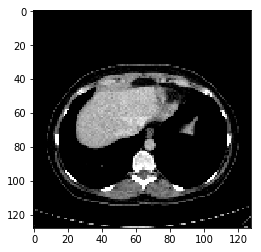

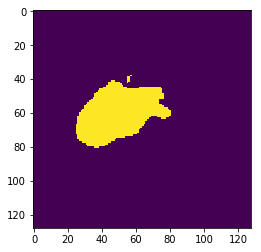

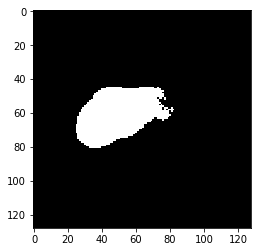

In [26]:
model.eval()
inputs = Variable(torch.from_numpy(val_images[4].reshape(1,1,128,128))).cuda()
out = model.forward(inputs)
out = np.argmax(out.data.cpu().numpy(), axis=1).reshape(128,128)
plt.figure()
plt.imshow(val_images[4], cmap = 'gray')
plt.figure()
plt.imshow(out)
plt.figure()
plt.imshow(val_labels[4],cmap = 'gray')

In [4]:
def display_image_label_and_output(image, label, output):
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(image, cmap = 'gray')
    plt.subplot(1,3,2)
    plt.imshow(image, cmap = 'gray')
    plt.imshow(label, alpha = 0.5)
    plt.subplot(1,3,3)
    plt.imshow(output, cmap = 'gray')
    plt.imshow(label, alpha = 0.5)
    plt.show()    

In [ ]:
def predict_on_test_data(model , image_path):
    test_files = os.listdir('test_images')
    test_imgs = [os.path.join('test_images',f) for f in test_files if 'img' in f][:n_files]
    test_labels = [f.replace('img', 'label') for f in test_imgs][:n_files]
    for f,g in zip(test_imgs, test_labels):
        img_arr = imageio.imread(f)
        img_arr = (np.float32(img_arr) - img_arr.min())/(img_arr.max() - img_arr.min())
        label_arr = imageio.imread(g)
        label_arr = np.uint8((label_arr - label_arr.min())/(label_arr.max() - label_arr.min()))
        # input to neural net has to be of form NCWH
        inputs = img_arr[None,None,:,:]
        inputs = Variable(torch.from_numpy(inputs), volatile = True)
        outs = model.forward(inputs)
        _, outs = torch.max(outs, 1)
        output_arr = outs.data.numpy()[0]
        display_image_label_and_output(img_arr, label_arr, output_arr)

In [ ]:
img_arr = imageio.imread(path)
#img_arr = (np.float32(img_arr) - img_arr.min())/(img_arr.max() - img_arr.min())
label_arr = imageio.imread(path)
#label_arr = np.uint8((label_arr - label_arr.min())/(label_arr.max() - label_arr.min()))
X = Variable(torch.from_numpy(X), volatile = True)
outs = model.forward(inputs)
_, outs = torch.max(outs, 1)
output_arr = outs.data.numpy()[0]


        
def predict(image) :
    output = 